# Fisher's Linear Discriminant

The goal of Fisher's linear discriminant is to find a unit vector $w$ such that the points can be classified by projecting onto this vector $w$ and assigning a threshold on the projections.
$w$ is found by:

$w \propto S_w^{-1}(m1-m2)$   
where $m1$ and $m2$ are the means of the projections of both classes

## Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
df = pd.read_csv("dataset_FLD.csv",header = None)
df.columns = ["feature 1","feature 2", "feature 3","label"]

In [3]:
df

,feature 1,feature 2,feature 3,label
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1
...,...,...,...,...
995,-3.680139,0.966962,-0.904337,0
996,-4.063900,0.802611,1.023708,1
997,-0.814430,-0.693945,0.876776,1
998,-0.325122,-0.759024,1.299772,1


In [4]:
# Split the data and labels into numoy arrays
data = df.values
X = data[:,:-1]
y = data[:,-1]

In [5]:
# .values converts the dataframe into numpy array
positives = df[df["label"] == 1].values
negatives = df[df["label"] == 0].values

## Visualize Data

The data has been plotted below into a 3D graph

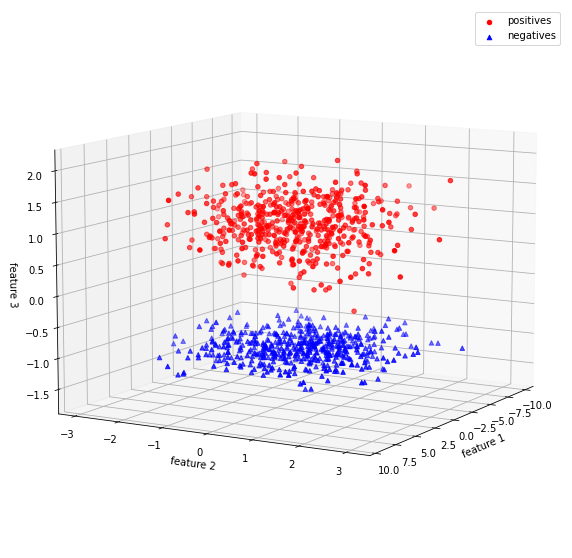

In [6]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(positives[:,0], positives[:,1], positives[:,2], c='r',marker='o')
ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("feature 3")
ax.view_init(10,30)
plt.legend(['positives','negatives'])

plt.show()

We now try to find the matrix $S_w$

In [7]:
labels = np.unique(df['label'].values)
features = X.shape[1]

# initialize S_w as zero matrices
S_w = np.zeros((features,features))

positive_mean = np.mean(X[y==1],axis=0)
negative_mean = np.mean(X[y==0],axis=0)

# go through both the classes
for label in labels:
    # collect data with that label
    X_class = X[y==label]
    N_class = X_class.shape[0]
    mu_c = np.mean(X_class,axis=0)
    
    # mu_c is broadcasted over first dimension of X_class
    # (500,3)*(3,500) = (3,3)
    S_w += (1/float(N_class))*(X_class - mu_c).T.dot((X_class - mu_c))
    

We then find $w$ from the formula $w \propto S_w^{-1}(m1-m2)$

In [8]:
mean_difference = (positive_mean - negative_mean).reshape(features,1)
w = np.linalg.inv(S_w).dot(mean_difference)
w = w/np.linalg.norm(w)
w

array([[-0.00655686],
       [-0.01823739],
       [ 0.99981218]])

In [9]:
positive_projections = X[y==1].dot(w)
negative_projections = X[y==0].dot(w)

## Plot of the normal distributions of the pdf's

The threshold is found by finding the intersection of the normal distributions. This is done by equating and finding the roots of a quadratic equation

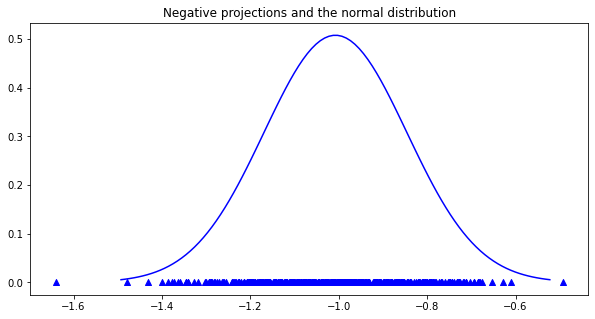

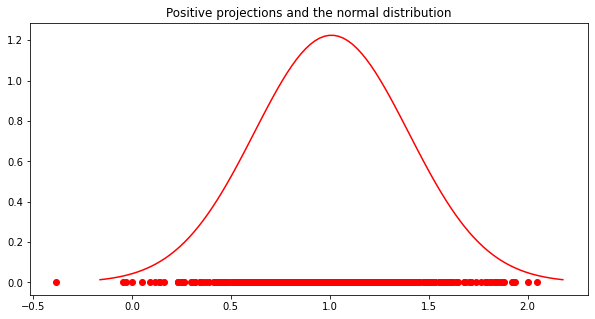

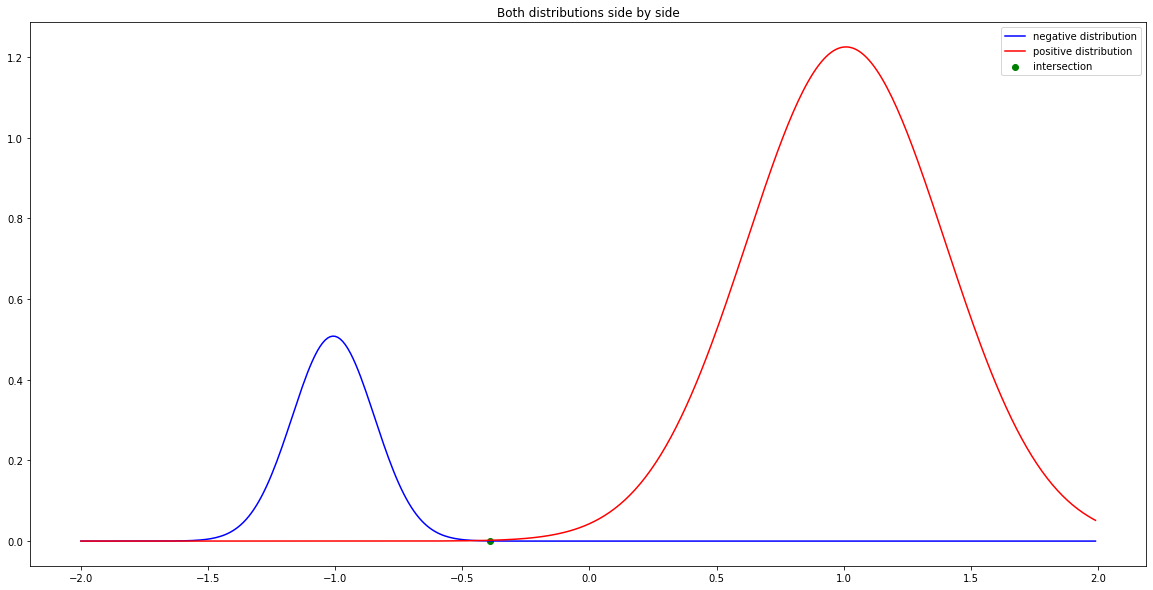

In [13]:
def norm_dist(x , mean , sd):
    """
    Returns the probability density function for the normal distribution
    Parameters:
        x: numpy array containing data
        mean: corresponding mean of the data
        sd: corresponding standard deviation of the data
        
    """
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def get_intersection(m1,m2,s1,s2):
    """
    Returns the roots obtained upon equating the normal distribution functions
    Parameters:
        m1: mean of the first class
        m2: mean of the second class
        s1: standard deviation of the first class
        s2: standard deviation of the second class
    
    """
    a = 1/(2*s1**2) - 1/(2*s2**2)
    b = m2/(s2**2) - m1/(s1**2)
    c = m1**2 /(2*s1**2) - m2**2 / (2*s2**2) - np.log(s2/s1)
    
    return np.roots([a,b,c])

def show_gaussians(X):
    """
    Plots the Normal distribution curves of the 2 classes
    Parameters:
        X: numpy array containing data
        
    """
    colors = ['b','r']
    markers = ['^','o']
    m=[0,0]
    s=[0,0]
    #plt.figure(figsize=(20, 10))
    # go through each class
    titles = ["Negative projections and the normal distribution","Positive projections and the normal distribution"]
    for i,label in enumerate(labels):
        # find corresponding projections of that class
        label_projections = X[y==label].dot(w)
        
        # mean of projections
        label_projections_mean = np.mean(label_projections)
        m[i]=label_projections_mean
        
        # std of projections
        label_projections_std = np.std(label_projections)
        s[i] = label_projections_std
        
        x_data = np.linspace(label_projections_mean - 3*label_projections_std, label_projections_mean + 3*label_projections_std, 100)
        plt.figure(figsize=(10, 5))
        plt.plot(x_data, norm_dist(x_data, label_projections_mean, label_projections_std),c=colors[i])
        plt.scatter(label_projections,np.zeros_like(label_projections),c=colors[i],marker=markers[i])
        plt.title(titles[i])
        plt.show()
        
    threshold = get_intersection(m[0],m[1],s[0],s[1])
    
    x_data = np.arange(-2,2,0.01)
    plt.figure(figsize=(20, 10))
    plt.plot(x_data, norm_dist(x_data, m[0], s[0]),c=colors[0])
    plt.plot(x_data, norm_dist(x_data, m[1], s[1]),c=colors[1])
    plt.scatter(np.array([threshold[-1]]),np.zeros_like(np.array([threshold[-1]])),c='g')
    plt.legend(['negative distribution','positive distribution','intersection'])
    plt.title("Both distributions side by side")
    plt.show()
    
    return threshold[-1]

threshold = show_gaussians(X)

The threshold is given here

In [11]:
threshold

-0.38930280209937657

The discriminant vector appears to classify the given dataset reasonably well

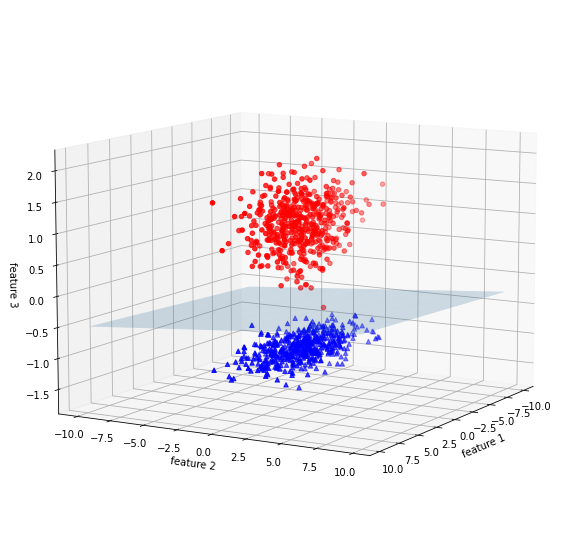

In [12]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
# initialize the x and y equally distant coordinates
xx,yy = np.meshgrid(np.arange(-10, 10, 0.25), np.arange(-10, 10, 0.25))
# find the z coordinate from the discriminant vector
Z = ((-w[0] * xx) - (w[1] * yy)  + threshold )  /w[2]

ax.plot_surface(xx, yy, Z, alpha=0.2)
ax.scatter3D(positives[:,0], positives[:,1], positives[:,2], c='r',marker='o')
ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
#plt.legend(['positives','negatives'])
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_zlabel("feature 3")
ax.view_init(10,30)